In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from pyspark.sql.functions import col, when, isnull

In [3]:
year = 2017
month = 11 # Month of CDR data +2

year_previous_month = 2017
previous_month = 10 # Month of CDR data +1

year_cdr_features = 2017
month_cdr_features = 9

In [4]:
pospago_month = (spark.read.table("raw_es.vf_pos_ac_final")
                   .where(col("year") == year)
                   .where(col("month") == month)
                  )

pospago_previous = (spark.read.table("raw_es.vf_pos_ac_final")
                    .where(col("year") == year_previous_month)
                    .where(col("month") == previous_month)
                    )

graph_table = (spark.read.table("tests_es.cdr_graph_features_no_communities")
               .where(col("year")==year_cdr_features)
               .where(col("month")==month_cdr_features)
               .where(col("for_training")==True)
               )

In [5]:
all_new_msisdns_pospago = (pospago_month.select(col("x_id_red"))
                           .dropDuplicates(subset=["x_id_red"])
                           .withColumnRenamed("x_id_red", "x_id_red_new")
                          )

In [6]:
dataset_pospago = (all_new_msisdns_pospago.join(pospago_previous,
                                               how="left",
                                               on=all_new_msisdns_pospago["x_id_red_new"] 
                                                   == pospago_previous["x_id_red"]
                                              )
                   .withColumn("new_customer", when(isnull(col("x_id_red")), 1).otherwise(0))
                   .select("x_id_red_new","new_customer")
                   )

In [7]:
dataset_pospago.groupBy("new_customer").count().show()

+------------+-------+
|new_customer|  count|
+------------+-------+
|           1| 264500|
|           0|7343284|
+------------+-------+



In [8]:
feature_columns = [column for column in graph_table.columns
                   if (column != "id") 
                   and ("community_id" not in column)
                   and ("es_vodafone" not in column)]

ml_dataset = graph_table.select(*(["id"]+feature_columns))

In [9]:
dataset_pospago_full = (ml_dataset
                        .join(dataset_pospago,
                              how="left",
                              on=ml_dataset["id"] == dataset_pospago["x_id_red_new"])
                        .withColumn("new_customer", when(col("new_customer") == 1, 1)
                                                   .when(col("new_customer") == 0, 0)
                                                   .otherwise(2)
                                   )
                        .where(col("new_customer").isin([1,2]))
                        .withColumn("new_customer", when(col("new_customer")==1, 1)
                                                    .otherwise(0)
                                   )
                        )

In [10]:
dataset_pospago_full.groupBy("new_customer").count().show()

+------------+--------+
|new_customer|   count|
+------------+--------+
|           1|   71644|
|           0|56548880|
+------------+--------+



In [11]:
splitted_dataset = dataset_pospago_full.randomSplit([0.8, 0.2])

train = splitted_dataset[0]
test = splitted_dataset[1]

In [12]:
spark.sparkContext.setCheckpointDir("hdfs:///user/jsotovi2/spark_checkpoints")
spark.conf.set("spark.sql.shuffle.partitions", 256)

In [13]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

rf = RandomForestClassifier(featuresCol="features",
                            labelCol="new_customer")

rf_pipeline = Pipeline(stages=[assembler, rf])

hyperparam_grid = (ParamGridBuilder()
                   .baseOn([rf.numTrees, 128])
                   .baseOn([rf.maxBins, 256])
                   .baseOn([rf.maxMemoryInMB, 3072])
                   .baseOn([rf.cacheNodeIds, False])
                   .baseOn([rf.checkpointInterval, 1])
                   
                   .addGrid(rf.maxDepth, [6])
                   .addGrid(rf.subsamplingRate, [0.6])
                   .addGrid(rf.featureSubsetStrategy, ["onethird"])
                   ).build()

roc_evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability", 
                                              labelCol="new_customer", 
                                              metricName="areaUnderROC")

validation_process = TrainValidationSplit(estimator=rf_pipeline, 
                                          estimatorParamMaps=hyperparam_grid, 
                                          evaluator=roc_evaluator, 
                                          trainRatio=0.75)

In [14]:
validation_process_model = validation_process.fit(train)

In [15]:
validation_lists = []

for hyperparam_combination in hyperparam_grid:
    validation_lists.append(dict([(hyperparam[0].name, hyperparam[1]) 
                                    for hyperparam in hyperparam_combination.items()])
                             )
    
validation_results = pd.DataFrame(validation_lists)
validation_results["valScore"] = validation_process_model.validationMetrics

In [16]:
validation_results.sort_values(by="valScore", ascending=False)

,cacheNodeIds,checkpointInterval,featureSubsetStrategy,maxBins,maxDepth,maxMemoryInMB,numTrees,subsamplingRate,valScore
0,False,1,onethird,256,6,3072,128,0.6,0.705604


In [23]:
validation_results.sort_values(by="valScore", ascending=False)

,cacheNodeIds,checkpointInterval,featureSubsetStrategy,maxBins,maxDepth,maxMemoryInMB,numTrees,subsamplingRate,valScore
1,False,1,onethird,256,15,3072,256,0.6,0.718416
3,False,1,sqrt,256,15,3072,256,0.6,0.717762
0,False,1,onethird,256,10,3072,256,0.6,0.717584
2,False,1,sqrt,256,10,3072,256,0.6,0.715643


In [17]:
best_model = validation_process_model.bestModel

print(best_model.stages[-1]._call_java("parent").extractParamMap().toString())

{
	RandomForestClassifier_451a804358600abddc4b-cacheNodeIds: false,
	RandomForestClassifier_451a804358600abddc4b-checkpointInterval: 1,
	RandomForestClassifier_451a804358600abddc4b-featureSubsetStrategy: onethird,
	RandomForestClassifier_451a804358600abddc4b-featuresCol: features,
	RandomForestClassifier_451a804358600abddc4b-impurity: gini,
	RandomForestClassifier_451a804358600abddc4b-labelCol: new_customer,
	RandomForestClassifier_451a804358600abddc4b-maxBins: 256,
	RandomForestClassifier_451a804358600abddc4b-maxDepth: 6,
	RandomForestClassifier_451a804358600abddc4b-maxMemoryInMB: 3072,
	RandomForestClassifier_451a804358600abddc4b-minInfoGain: 0.0,
	RandomForestClassifier_451a804358600abddc4b-minInstancesPerNode: 1,
	RandomForestClassifier_451a804358600abddc4b-numTrees: 128,
	RandomForestClassifier_451a804358600abddc4b-predictionCol: prediction,
	RandomForestClassifier_451a804358600abddc4b-probabilityCol: probability,
	RandomForestClassifier_451a804358600abddc4b-rawPredictionCol: rawP

In [18]:
best_model.save("hdfs:///user/jsotovi2/captacion/2017_12_21__modelo_captacion.sparkmodel")

In [19]:
predictions_test = best_model.transform(test)

roc_evaluator.evaluate(predictions_test)

0.7054538677626285

In [20]:
feature_importance = pd.DataFrame({"feature": feature_columns,
                                   "importance": best_model.stages[-1].featureImportances}
                                 ).sort_values(by="importance", ascending=False)

feature_importance

,feature,importance
43,received_vf_calls_pospago_19PM_1AM,0.220091
53,n_mins_received_vf_pospago_19PM_1AM,0.111178
40,received_calls_19PM_1AM,0.059352
44,received_vf_calls_ratio_pospago_19PM_1AM,0.055582
45,emited_calls_19PM_1AM,0.054328
54,ratio_mins_received_vf_pospago_19PM_1AM,0.054043
23,received_vf_calls_pospago_15PM_18PM,0.032471
4,received_vf_calls_ratio_pospago_6AM_14PM,0.032153
0,received_calls_6AM_14PM,0.025503
25,emited_calls_15PM_18PM,0.020840


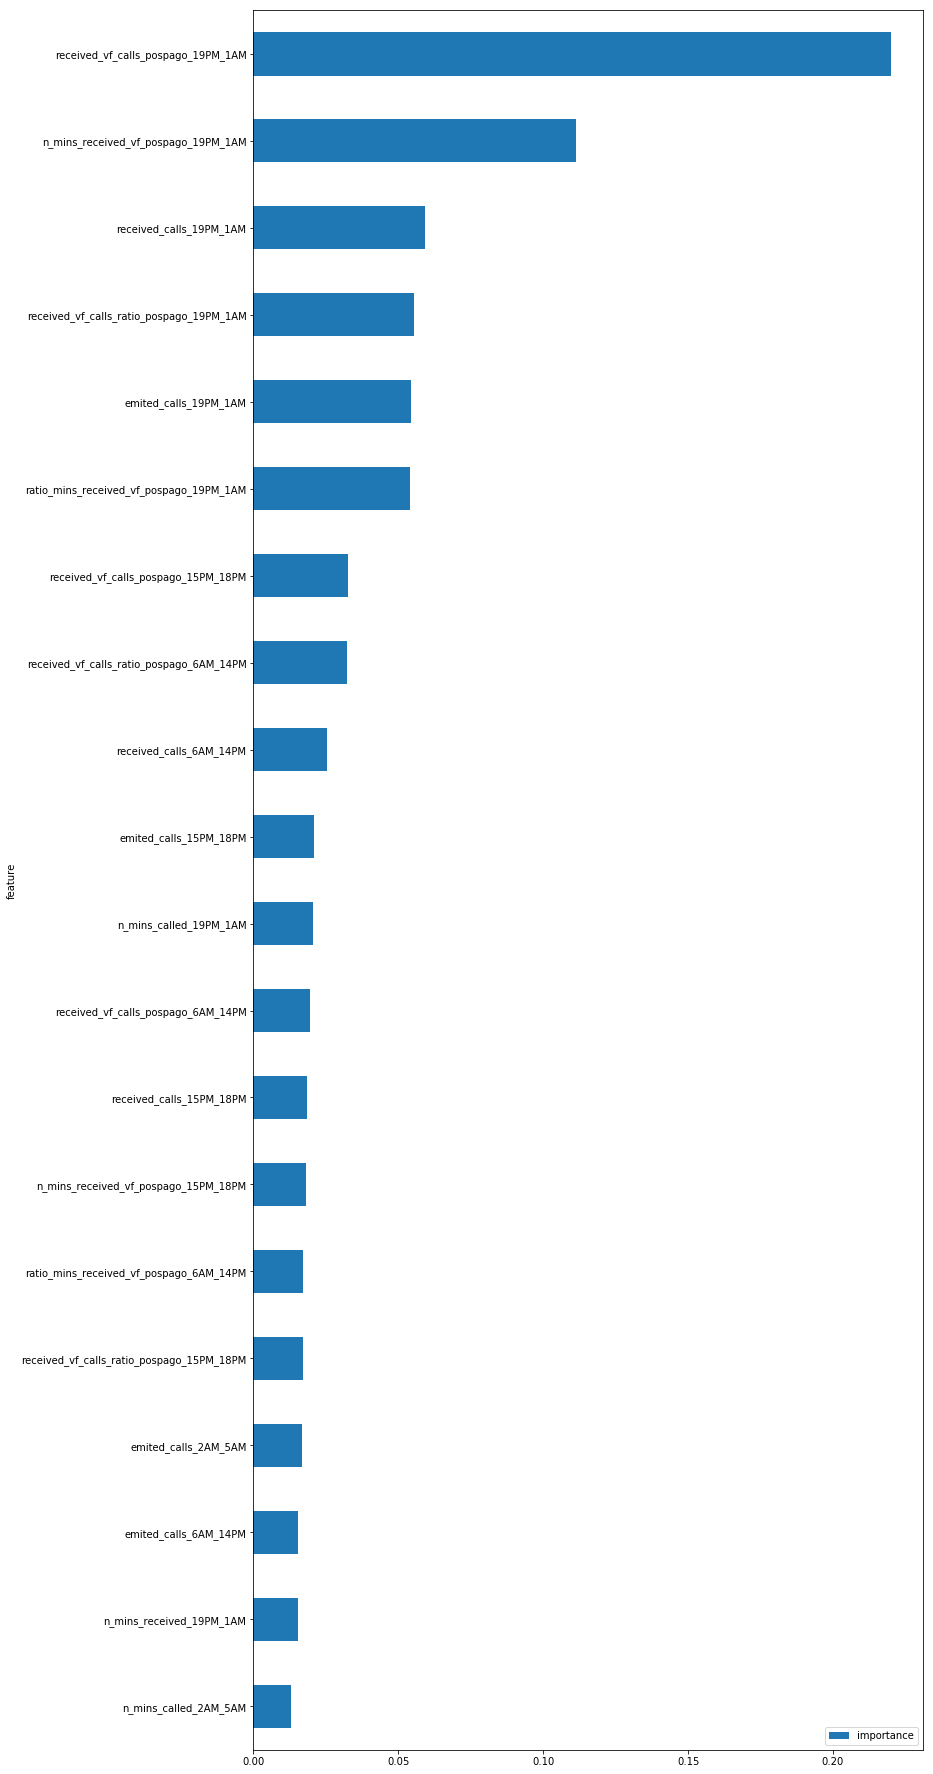

In [21]:
(feature_importance[:20]
 .sort_values(by="importance", ascending=True)
 .plot(kind="barh", x="feature", y="importance", figsize=(12,32))
 )